In [1]:
%load_ext autoreload
%autoreload 2

In [2]:

import os
import sys
import json

import argparse

from dataclasses import dataclass

In [3]:

from matplotlib import rcParams
from matplotlib import font_manager
%matplotlib inline

In [4]:
# resource configuration
rcParams['figure.dpi'] = 200

# fount information
rcParams['font.family'] = 'Equinor'
rcParams['font.size'] = 9

# fornt location
font_path = r'Equinor_regular'
font_files = font_manager.findSystemFonts(fontpaths=font_path)

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

In [5]:
# where WellClass and Ga[ codes are located
sys.path.append('../')

In [6]:

from src.WellClass.libs.utils import (
    csv_parser,
    yaml_parser,
)

# WellClass
from src.WellClass.libs.well_class import Well

from src.WellClass.libs.grid_utils import (
    WellDataFrame,
    LGRBuilder,
)

# plots
from src.WellClass.libs.plotting import (
    plot_grid,
)


## Some user options

In [7]:
# TODO(hzh): use Ali's algorithm
Ali_way = False
# Ali_way = True


In [8]:
# use yaml or csv input file
use_yaml = True


In [9]:

# pick an example from given three options

case_type = 'cosmo'

# # the refdepth is not corrected, 
# case_type = 'smeaheia_v1'

# # the refdepth is corrected, so don't use Ali_way for this case
# case_type = 'smeaheia_v2'

In [10]:
# where test data located
data_path = '../'

## Examples

In [11]:

# # Examples
# The following are the test examples.

# examples
smeaheia_v1 = {'well_input': r'GaP_input_Smeaheia_v3.csv', 
            'well_input_yaml': r'smeaheia.yaml', 
            #    'sim_path': r'/scratch/SCS/eim/SMEAHEIA', 
            'sim_path': os.path.join(data_path, './test_data/examples/smeaheia_v1'),
            'simcase': r'GEN_NOLGR_PH2'}
smeaheia_v2 = {'well_input': r'GaP_input_Smeaheia_v3.csv', 
            'well_input_yaml': r'smeaheia.yaml', 
            #    'sim_path': r'/scratch/SCS/bkh/wbook/realization-0/iter-0/pflotran/model', 
            'sim_path': os.path.join(data_path, './test_data/examples/smeaheia_v2'), 
            'simcase': r'TEMP-0'}
cosmo = {
        'well_input': r'GaP_input_Cosmo_v3.csv', 
        'well_input_yaml': r'cosmo.yaml', 
        #  'sim_path': r'/scratch/SCS/bkh/well_class_test1/realization-0/iter-0/pflotran/model', 
        'sim_path': os.path.join(data_path, './test_data/examples/cosmo'), 
        'simcase': r'TEMP-0'}

examples = {
    'smeaheia_v1': smeaheia_v1,
    'smeaheia_v2': smeaheia_v2,
    'cosmo': cosmo
}


In [12]:

@dataclass                # @dataclass(kw_only=True)
class Arguments:
    ali_way: bool
    use_yaml: bool
    case_type: str
    output_dir: str = '.'
    output_name: str = 'LEG_HIRES'
    plot: bool = True

In [13]:

args = Arguments(ali_way=Ali_way, use_yaml=use_yaml, case_type=case_type)

In [14]:


############# 0. User options ######################

# TODO(hzh): use Ali's grid logic
Ali_way = args.ali_way

# use yaml or csv input file
use_yaml = args.use_yaml

# pick an example from given three options: 
#  i.e, smeaheia_v1, smeaheia_v2 and cosmo
case_type = args.case_type

# output
output_dir = args.output_dir
# LRG name 
LGR_NAME = args.output_name


In [15]:

############# 1. Selected case ####################

# the selected example for testing
case = examples[case_type]

# root folder for the input parameters, where .yaml or .csv are located
sim_path = case['sim_path']


## Load well configuration file

In [16]:

############ 2. Load well configuration file ###############

if use_yaml:
    # where well configuration file is located
    well_name = os.path.join(sim_path, case['well_input_yaml'])
    
    # # pydantic model
    well_model = yaml_parser(well_name)
    well_csv = json.loads(well_model.spec.model_dump_json())
else:
    # where well configuration file is located
    well_name = os.path.join(sim_path, case['well_input'])

    # load the well information
    well_csv = csv_parser(well_name)


## Build well class

In [17]:

########### 3. build Well class ######################

# build well class
my_well = Well( header       = well_csv['well_header'], 
                drilling     = well_csv['drilling'],
                casings      = well_csv['casing_cement'],
                geology      = well_csv['geology'],
                barriers     = well_csv['barriers'], 
                barrier_perm = well_csv['barrier_permeability'],
                co2_datum    = well_csv['co2_datum'],
        )


In [18]:

# to well dataframe
well_df = WellDataFrame(my_well)

# for convenience

# extract dataframes
annulus_df = well_df.annulus_df
drilling_df = well_df.drilling_df
casings_df = well_df.casings_df
borehole_df = well_df.borehole_df

barriers_mod_df = well_df.barriers_mod_df


## Build LGR grids

In [19]:

# location of .egrid
simcase = os.path.join(sim_path, 'model', case['simcase'])

# LGR grid information in x, y, z directions
lgr = LGRBuilder(simcase, 
                annulus_df, 
                drilling_df,
                Ali_way)


Coarse grid dimension: nx=20, ny=20, nz=60
Minimimum grid size is 5.24 cm
LGR dimension: nx=22, ny=22, nz=150


In [20]:

########### output grdecl file ###################

# Write LGR file
gap_casing_df = lgr.build_grdecl(output_dir, LGR_NAME,
                                 drilling_df,
                                 casings_df,
                                 barriers_mod_df)


...Prints isolating OVB from reservoir keywords in LEG_HIRES.grdecl file
...Prints CARFIN Keywords in LEG_HIRES.grdecl file
...Prints isolating OVB from reservoir in the LGR in LEG_HIRES.grdecl file
Output LGR CARFIN to:  /project/dig_ccs_sub/users/hzh/projects/SCREEN/notebooks/LEG_HIRES.grdecl


# Visualization

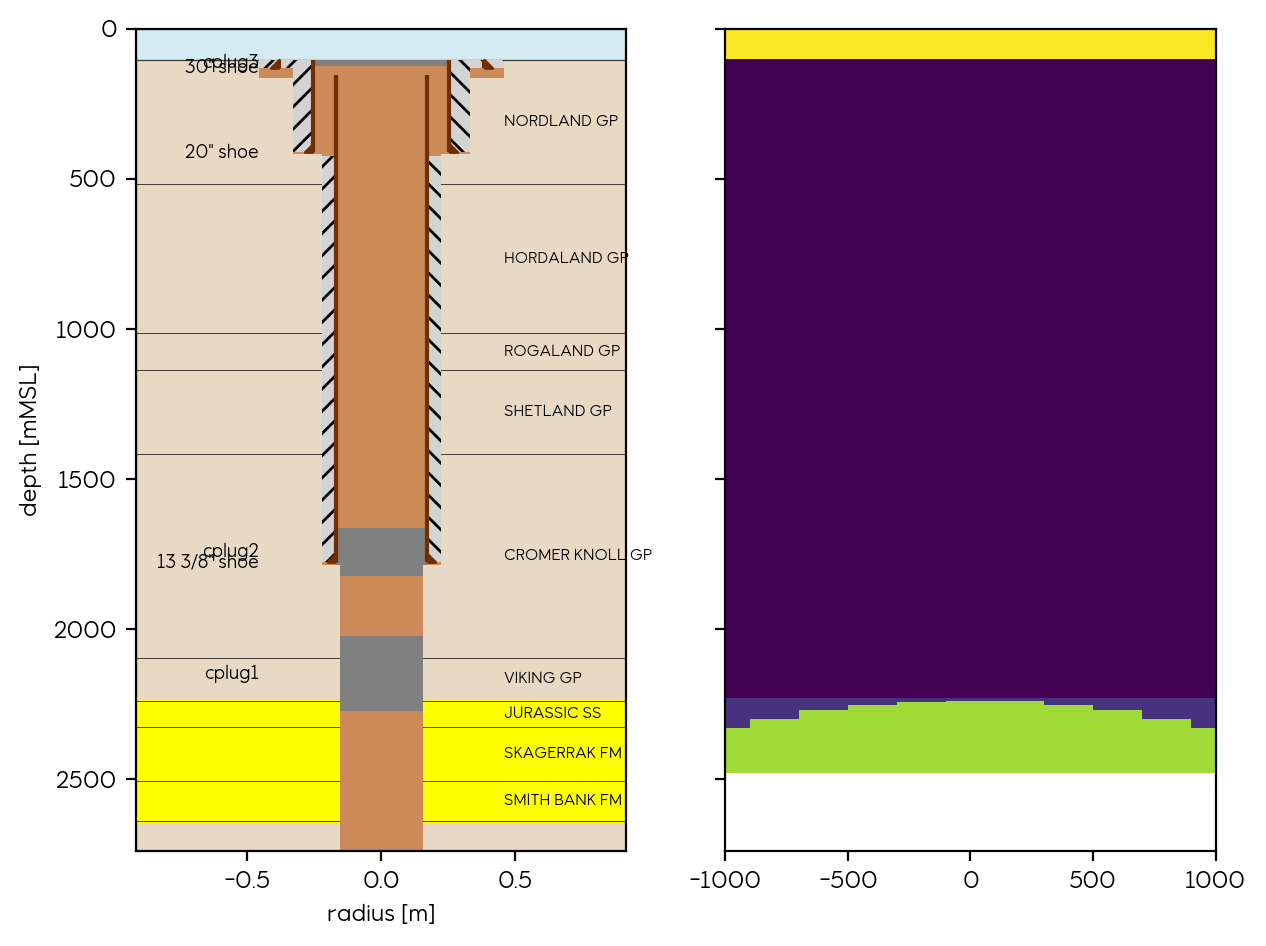

In [21]:

# for qc
if args.plot:
    grid_coarse = lgr.grid_coarse
    plot_grid(my_well, grid_coarse)

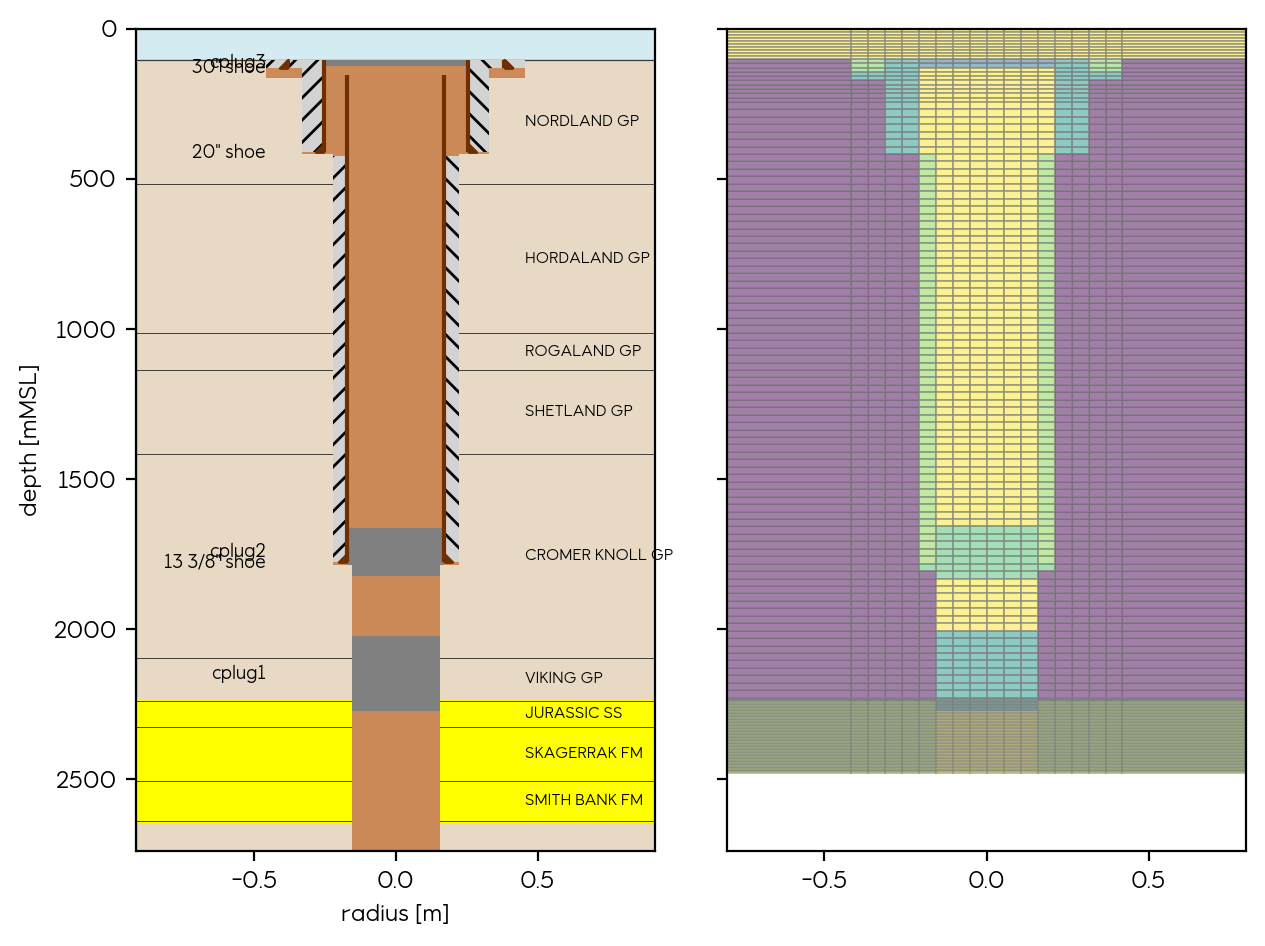

In [22]:
if args.plot:
    grid_refine = lgr.grid_refine
    plot_grid(my_well, grid_refine)

# Pytest

In [23]:
# flags for pytest unit/integration testing

# save data for pytest
PYTEST_FLAG = False 


In [24]:

# NOTE: please try not to change the followings, unless you know what you are doing

# Note: only handle cosmo case for simplicity
CASE_TEST = case_type == 'cosmo'

# where to save pytest data
PYTEST_FOLDER = 'pytest'


In [25]:

# determine pytest flag
PYTEST_SAVE = CASE_TEST and PYTEST_FLAG

In [26]:

if PYTEST_SAVE:
    # Note: have to use pickle to keep integer key as integer
    import pickle
    import pathlib

    # folder to save pytest data
    pytest_path = pathlib.Path(sim_path)/PYTEST_FOLDER

    # build the folder if it doesn't exist
    # NOTE: I intentionally make the 'parents=False'
    pytest_path.mkdir(parents=False, exist_ok=True)

In [27]:
# save WellClass for pytest unit/integration testing
if PYTEST_SAVE:
    #
    well_input_name = case['well_input_yaml'].replace('.yaml', '_well_pytest.pkl')
    well_dict_name = pytest_path/well_input_name
    
    with open(well_dict_name, 'wb') as pkl_file:
        pickle.dump(my_well.__dict__, pkl_file)

In [28]:
# save WellClass dataframe for pytest unit/integration testing
if PYTEST_SAVE:
    #
    well_input_name = case['well_input_yaml'].replace('.yaml', '_lgr_pytest.pkl')
    lgr_dict_name = pytest_path/well_input_name
    
    with open(lgr_dict_name, 'wb') as pkl_file:
        pickle.dump(lgr.__dict__, pkl_file)